# This uses an older version of celmech on gandalf

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')
from multiprocessing import Pool   
from celmech.disturbing_function import get_fg_coeffs
from celmech import Andoyer, Poincare
from celmech.resonances import resonant_period_ratios, resonance_pratio_span
from celmech.nbody_simulation_utilities import set_timestep,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
from celmech.nbody_simulation_utilities import reb_add_from_elements
import rebound as rb
from celmech.secular import LaplaceLagrangeSystem
from subprocess import call

ImportError: cannot import name 'get_fg_coeffs' from 'celmech.disturbing_function' (/Users/dtamayo/Documents/workspace/celmech/celmech/disturbing_function.py)

In [2]:
def sec(sim, i1, i2):
    if i1 > i2:
        raise AttributeEror("i2 must be exterior body")
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['L10'] = res['Lambda'][i1-1]
    res['L20'] = res['Lambda'][i2-1]
    res['L12'] = res['L10'] + res['L20']
    res['Lr'] = res['L10']*res['L20']/res['L12']
    res['psi'] = np.pi + np.arcsin(np.sqrt(res['L10']/res['L12']))
    res['R'] = np.identity(res['Lambda'].shape[0]) # Nplanets x Nplanets rotation matrix
    # Only rotate the 2x2 submatrix corresponding to i1 and i2 with rotation matrix
    res['R'][np.ix_([i1-1,i2-1],[i1-1, i2-1])] = np.array([[np.cos(res['psi']), -np.sin(res['psi'])], [np.sin(res['psi']), np.cos(res['psi'])]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    res['S'] = np.identity(res['Lambda'].shape[0])*np.sqrt(res['Lr']) # Nplanets x Nplanets rotation matrix
    for i, L in enumerate(res['Lambda']):
        res['S'][i,i] /= np.sqrt(L)
    eigvals= lsys.eccentricity_eigenvalues()
    res['Tsec'] = np.abs(2 * np.pi / eigvals)
    return res

def two_planets_eigen(seed, P21, e, mu):
    np.random.seed(seed)
    P12 = 1/P21
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['R'] @ secsim['M'] @ secsim['R'].T
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    # initialize in e- eigenmode
    A = [1,0]
    v0 = T @ A
    v0 /= np.linalg.norm(v0)
    
    zstar = secsim['S'] @ secsim['R'].T @ v0
    zstar = zstar/(zstar[1]-zstar[0]) # normalize so em12 = 1
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi}, sim=sim)
    
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    minTperi = ps[1].P*(1-ps[1].e)**1.5/(1+ps[1].e)**0.5
    sim.dt = minTperi/20
    
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_two_planets_eigen(params):
    seed, P21, e, mu, tmax = params
    sim = two_planets_eigen(seed, P21, e, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.min(np.abs(2 * np.pi / eigvals)) # Take shorter one since longer one very large due to ecom conserv.
        tmax = 3*Tsec
        #print("{0:3e}".format(tmax))
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

def eq_mass_mixed_eigen(seed, P21, P3, e, mu):
    np.random.seed(seed)
    P12 = 1/P21
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12, 'M':np.pi}, sim=sim)
    reb_add_from_elements(m=mu*10, elements={'P':P3}, sim=sim)
    sim.move_to_com()

    secsim = sec(sim, 1, 2)
    Mprime = secsim['R'] @ secsim['M'] @ secsim['R'].T
    vals,T = np.linalg.eigh(Mprime)
    freqs = np.diag(np.diag(vals))
    
    A = [1,0,0]
    v0 = T @ A
    v0 /= np.linalg.norm(v0)
    A = [0,1,0]
    v1 = T @ A
    v1 /= np.linalg.norm(v1)
    v = -2/v0[0]*v0 + 1/v1[0]*v1 # init such that A0 contributes -2 to e-, and A1 contributes +1
    zstar = secsim['S'] @ secsim['R'].T @ v
    
    sim = rb.Simulation()
    sim.add(m=1)
    reb_add_from_elements(m=mu/3, elements={'P':1,'e':abs(zstar[0])*e, 'pomega':np.arccos(np.sign(zstar[0])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu/3, elements={'P':1/P12,'e':abs(zstar[1])*e, 'pomega':np.arccos(np.sign(zstar[1])), 'M':np.random.random()*2*np.pi}, sim=sim)
    reb_add_from_elements(m=mu*10, elements={'P':P3,'e':abs(zstar[2])*e, 'pomega':np.arccos(np.sign(zstar[2])), 'M':np.random.random()*2*np.pi}, sim=sim)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision="direct"
    ps = sim.particles
    minTperi = ps[1].P*(1-ps[1].e)**1.5/(1+ps[1].e)**0.5
    sim.dt = minTperi/20
    
    for p in ps[1:]:
        p.r = p.a*(p.m/3)**(1/3)
        
    return sim

def megno_eqmass_eigen(params):
    seed, P21, P3, e, mu, tmax = params
    sim = eq_mass_mixed_eigen(seed, P21, P3, e, mu)
    if tmax is None:
        lsys = LaplaceLagrangeSystem.from_Simulation(sim)
        eigvals = lsys.eccentricity_eigenvalues()
        Tsec = np.abs(2 * np.pi / eigvals)
        tmax = 3*Tsec[1]
    sim.init_megno()
    try:
        sim.integrate(tmax)
    except:
        megno = 1000
        return megno
    megno = sim.calculate_megno()
    if np.isnan(megno):
        megno = 1000
    return megno

In [3]:
def get_pool_params(xlist, ylist, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, y, mu, tmax))
            ctr += 1
    return params
             
def get_pool_params_P3(xlist, ylist, P3, mu=1e-4, tmax=None):
    params = []
    ctr = 0
    for y in ylist:
        for x in xlist:
            params.append((ctr, x, P3, y, mu, tmax))
            ctr += 1
    return params

def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
def ecross(j, k):
    return 2*k/(3*j)

In [4]:
mu=1e-4
eps = 2*mu/3
Pmin = 1.35
Pmax = 1.48
emax = 0.2
NPs = 800
Nes = 800
P21s = np.linspace(Pmin, Pmax, NPs)
es = np.linspace(0, emax, Nes)

In [5]:
%%time
params2p = get_pool_params(P21s, es, mu=mu, tmax=None)
pool = Pool()
results2p = pool.map(megno_two_planets_eigen, params2p)
np.save('2p10Mearth_unnormalized.npy', results2p)

CPU times: user 27.3 s, sys: 15.3 s, total: 42.6 s
Wall time: 4h 29min 36s


In [ ]:
# Make IKEA color map

In [8]:
from matplotlib.colors import LinearSegmentedColormap

ikeablue_r = 36/256
ikeablue_g = 86/256
ikeablue_b = 158/256

ikeagold_r = 245/256
ikeagold_g = 219/256
ikeagold_b = 76/256

cdict = {'red':   [[0.,  ikeablue_r, ikeablue_r],
                   [1.,  ikeagold_r, ikeagold_r]],
         'green': [[0.,  ikeablue_g, ikeablue_g],
                   [1.,  ikeagold_g, ikeagold_g]],
         'blue':  [[0.,  ikeablue_b, ikeablue_b],
                   [1.,  ikeagold_b, ikeagold_b]]}

ikeacmap = LinearSegmentedColormap('ikeacmap', segmentdata=cdict, N=256)

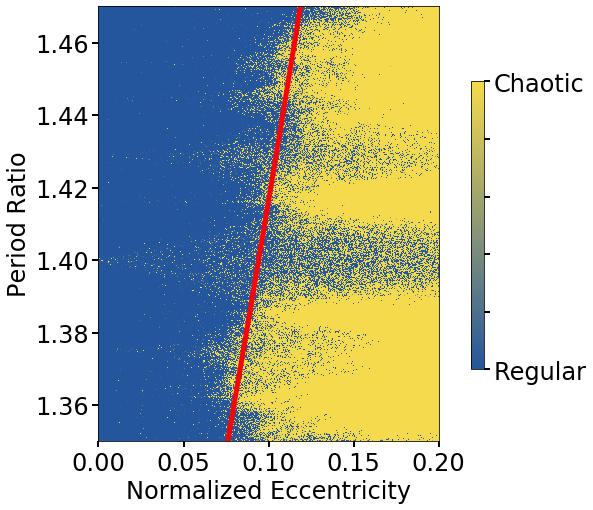

In [9]:
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(9, 8))

deltas = (1-P21s**(-2/3))/(2*mu/3)**(1/4)
res2p = np.load('2p10Mearth_unnormalized.npy')

X,Y,Z = get_centered_grid(P21s, es, np.array(res2p)-2)
im = ax.pcolormesh(Y, X, Z, vmin=0, vmax=1, cmap=ikeacmap, rasterized=True)
ax.plot(np.exp(-2.2*deltas**(-4/3))*(1-P21s**(-2/3)), P21s, lw=5, color='red')

ax.set_ylabel(r"Period Ratio", fontsize=24)
ax.set_xlabel(r"Normalized Eccentricity", fontsize=24)
ax.set_ylim([1.35, 1.47])
ax.set_xlim([es.min(), es.max()])

fig.subplots_adjust(right=0.65)
cbar_ax = fig.add_axes([0.7, 0.25, 0.02, 0.5])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=24)
cb.set_ticks([im.colorbar.vmin + t*(im.colorbar.vmax-im.colorbar.vmin) for t in cb.ax.get_yticks()])
cb.set_ticklabels(['Regular', '', '', '', '', 'Chaotic'])

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)

In [6]:
%%time
params = get_pool_params_P3(P21s, es, P3=3.2, mu=mu, tmax=2e4)
pool = Pool()
results = pool.map(megno_eqmass_eigen, params)
np.save('mixedeigenmode_unnormalized.npy', results)

CPU times: user 44.7 s, sys: 40 s, total: 1min 24s
Wall time: 3h 6min 8s


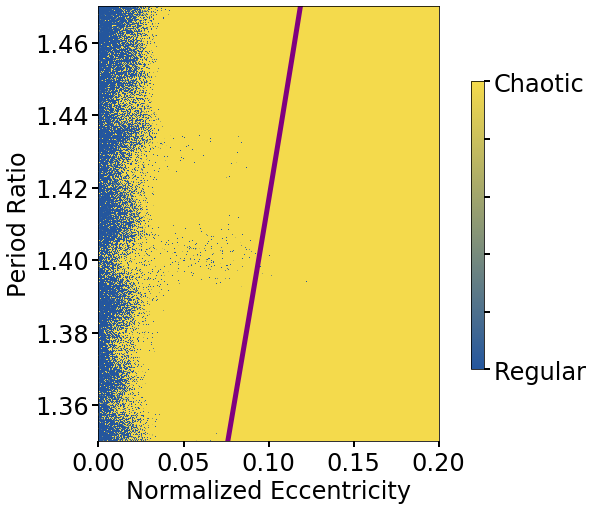

In [10]:
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(9, 8))

deltas = (1-P21s**(-2/3))/(2*mu/3)**(1/4)
res2p = np.load('mixedeigenmode_unnormalized.npy')

X,Y,Z = get_centered_grid(P21s, es, np.array(res2p)-2)
im = ax.pcolormesh(Y, X, Z, vmin=0, vmax=1, cmap=ikeacmap, rasterized=True)
ax.plot(np.exp(-2.2*deltas**(-4/3))*(1-P21s**(-2/3)), P21s, lw=5, color='purple')

ax.set_ylabel(r"Period Ratio", fontsize=24)
ax.set_xlabel(r"Normalized Eccentricity", fontsize=24)
ax.set_ylim([1.35, 1.47])
ax.set_xlim([es.min(), es.max()])

fig.subplots_adjust(right=0.65)
cbar_ax = fig.add_axes([0.7, 0.25, 0.02, 0.5])
#cbar_ax.axis('off')
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=24)
cb.set_ticks([im.colorbar.vmin + t*(im.colorbar.vmax-im.colorbar.vmin) for t in cb.ax.get_yticks()])
cb.set_ticklabels(['Regular', '', '', '', '', 'Chaotic'])

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=8)

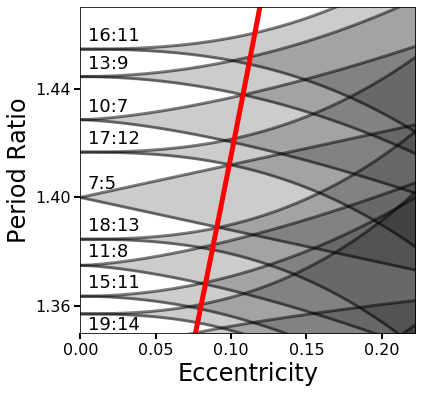

In [71]:
fig, ax = plt.subplots(figsize=(6,6))

ax.set_ylim([1.35, 1.47])
ax.set_xlim([0,ecross(j=3,k=1)]) # ecross for the widest (3:2 MMR)
ax.set_xlabel('Eccentricity',fontsize=24)
ax.set_ylabel('Period Ratio',fontsize=24)
h = [0, 0.535, 0.426, 0.420, 0.454, 0.519, 0.613, 0.742, 0.914, 1.143, 1.445] # coefficients for k order resonances

jmax=20
kmax=5
res = []
for k in range(1,kmax+1):
    for j in range(2*k+1, jmax):
        if not relativelyprime(j, k):
            continue
        P21 = j/(j-k) # P2/P1
        alpha = P21**(-2/3)
        eps = mu/3*(1 + alpha**(1/6))
        if P21 > 1/P12s.max()-0.05 and P21 < 1/P12s.min()+0.05:
            #ax.text(P21-0.005, 0.48-0.02*k, '{0}:{1}'.format(j, j-k), fontsize=20)
            es = np.linspace(0, ax.get_xlim()[1], 100)
            ec = ecross(j,k)
            dPs = (j/(j-k))**(2/3)*2*np.sqrt(3)*h[k]**(1/2)*eps**(1/2)*(es/ec)**(k/2)
            ax.plot(es, P21+dPs, 'k', alpha=0.5)
            ax.plot(es, P21-dPs, 'k', alpha=0.5)
            ax.fill_between(es, P21-dPs, P21+dPs, alpha=0.2, color='k')
        if P21 > 1/P12s.max() and P21 < 1/P12s.min():
            res.append((j, k))
P12s = np.linspace(1/ax.get_ylim()[1], 1/ax.get_ylim()[0], 100)
ecs = 1 - P12s**(2/3)
deltas = (1-P12s**(2/3))/eps**(1/4)
ax.plot(np.exp(-2.2*deltas**(-4/3))*ecs, 1/P12s, lw=5, color='red')


for j, k in res:
    if j != 19:
        ax.text(0.005, j/(j-k)+0.003, '{0}:{1}'.format(j, j-k), fontsize=18)
    else:
        ax.text(0.005, j/(j-k)-0.006, '{0}:{1}'.format(j, j-k), fontsize=18)
ax.set_yticks([1.36, 1.4, 1.44])
